In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.calibration import calibration_curve
from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from sklearn.metrics import make_scorer
from sklearn.metrics import average_precision_score
from sklearn.model_selection import cross_val_score as cv_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder

#### Executive Summary

Given that the boosted trees model had a slightly higher AUC, it would likely perform better on the test set. However, the baseline logistic regression model has better calibrated probability estimates. Given how similar the performance between these two models is, it might be unnecessary to deploy the machine learning model. Depending on the needs of the business, the logistic regression model might be sufficient. In many cases ML is overkill, hence the importance of having a simple baseline model for comparison.

- Performance
These performance estimates are generated from cross validation, which should be a reasonable approximation of the expected test set performance. Looking at AUC alone, the boosted trees model is expected to slightly outperform the baseline logistic regression model. However, it is important to note that the probabilities from the regression model are more calibrated.

| Model | Regression | Boosted Trees |
| --- | --- | --- |
| AUC | 0.540 | 0.556 | 

- Method
A baseline calibrated logistic regression model and a boosted trees classification model were compared. The baseline logistic regression model had a lasso (L1) penalty and Platt scaling for probability calibration. Performances were compared using 10 fold cross validation. Learning curve diagnostics suggest that the models could benefit from gathering more data.

- Pros vs. Cons
The baseline logistic regression model has the benefit of being simple and fast to train. Additionally, the use of Platt scaling to calibrate the probabilities resulted in better calibration relative to the boosted trees model. A drawback of the regression model is the assumption of a linear relationship between the covariates and the target class. This could be improved somewhat by including pairwise interactions. In contrast, the boosted trees model can account for pairwise interactions and reduce bias. During model training, it reduces bias by focusing more on misclassified examples within each subsequent tree. The downside of training the ML model is the computational time required and the size of the model in memory.

- Caveat
There was no column denoting the relative time of each row. There is a concern that the cross validation results are biased as time series cross validation was not used. There was no way to ensure that there is no temporal data leakage across validation splits or between the train and test data.

In [2]:
DATA_PATH = "./data/"
data_tr = pd.read_csv(DATA_PATH + "exercise_40_train.csv")
data_te = pd.read_csv(DATA_PATH + "exercise_40_test.csv")

#### Data Explore

In [3]:
data_tr.dtypes, data_te.dtypes

(y         int64
 x1      float64
 x2      float64
 x3       object
 x4      float64
          ...   
 x96     float64
 x97     float64
 x98       int64
 x99      object
 x100    float64
 Length: 101, dtype: object,
 x1      float64
 x2      float64
 x3       object
 x4      float64
 x5      float64
          ...   
 x96     float64
 x97     float64
 x98       int64
 x99      object
 x100    float64
 Length: 100, dtype: object)

In [4]:
data_tr.describe()

,y,x1,x2,x4,x5,x6,x8,x9,x10,x11,...,x89,x90,x91,x92,x94,x95,x96,x97,x98,x100
count,40000.000000,40000.000000,40000.000000,40000.000000,37572.000000,40000.000000,40000.000000,40000.000000,40000.000000,34890.000000,...,29309.000000,40000.000000,34741.000000,37565.000000,37660.000000,27396.000000,33362.000000,40000.000000,40000.000000,40000.000000
mean,0.145075,2.999958,20.004865,0.002950,0.005396,0.007234,0.004371,2.722334,0.490339,100.008988,...,10.767838,3.000166,0.001636,4.002896,3.969385,0.031886,10.525530,10.002814,0.497650,100.024743
std,0.352181,1.994490,1.604291,1.462185,1.297952,1.358551,1.447223,1.966828,1.029863,13.343010,...,3.732763,1.164411,1.468790,3.017420,1.473939,1.823091,1.437581,1.986984,0.500001,5.247514
min,0.000000,-3.648431,13.714945,-5.137161,-5.616412,-6.113153,-6.376810,-3.143438,-3.538129,50.526543,...,6.106024,-2.173310,-6.328126,-3.384399,-1.663063,-6.885150,8.210456,1.911272,0.000000,78.340735
25%,0.000000,1.592714,18.921388,-1.026798,-0.872354,-0.909831,-0.971167,1.340450,-0.207833,91.056682,...,7.927605,2.211125,-0.982679,1.610899,2.943758,-1.190682,9.397548,8.665103,0.000000,96.516856
50%,0.000000,2.875892,20.005944,0.002263,0.008822,0.007335,0.002226,2.498876,0.486926,100.020965,...,9.931831,2.998776,0.005664,4.099763,3.912526,0.001523,10.358355,9.994318,0.000000,100.024977
75%,0.000000,4.270295,21.083465,1.043354,0.892467,0.926222,0.985023,3.827712,1.182994,109.025025,...,12.710543,3.786751,0.989632,6.113157,4.930563,1.248742,11.448559,11.342574,1.000000,103.558762
max,1.000000,13.837591,27.086468,5.150153,5.698128,5.639372,5.869889,18.006669,4.724186,148.784484,...,38.566041,7.130058,6.868747,16.734658,11.669024,7.631773,18.725468,17.861580,1.000000,122.406809


In [5]:
data_tr.isnull().sum(), data_te.isnull().sum() # some data is missing

(y           0
 x1          0
 x2          0
 x3          0
 x4          0
         ...  
 x96      6638
 x97         0
 x98         0
 x99     12836
 x100        0
 Length: 101, dtype: int64,
 x1         0
 x2         0
 x3         0
 x4         0
 x5       602
         ... 
 x96     1628
 x97        0
 x98        0
 x99     3300
 x100       0
 Length: 100, dtype: int64)

In [6]:
data_tr.y.value_counts() # this is a binary classification problem

0    34197
1     5803
Name: y, dtype: int64

In [7]:
data_tr.shape, data_te.shape

((40000, 101), (10000, 100))

In [8]:
print(f"The positive class frequency is {round(data_tr.y.sum()/data_tr.shape[0],1)}%.")

The positive class frequency is 0.1%.


There are no column names so it isn't clear what some of this data represents. There is missing data and it isn't clear if it is MNAR or missing completely at random. To be safe, a dummy variable will be created to account for missingness. For missing values where the feature column is a float, median imputation will be used to fill in the missing data. Given the massive class imbalance, it's important to check the calibration of the model's probability estimates. It isn't clear if there is any temporal dependence in the data. If there is, it is important to use time series cross validation to respect the order of the data over time. Using k-fold cross validation and shuffling the data could lead to data leakage and biased performance estimates.

#### Data Preprocess

In [9]:
CAT_COLS = data_tr.select_dtypes(include = 'object').columns # categorical columns
data_tr[CAT_COLS].head

<bound method NDFrame.head of              x3        x7                 x19     x24  x31        x33  \
0           Wed   0.0062%  $-908.650758424405  female   no   Colorado   
1        Friday   0.0064%   $-1864.9622875143    male   no  Tennessee   
2      Thursday   -8e-04%  $-543.187402955527    male   no      Texas   
3       Tuesday  -0.0057%  $-182.626380634258    male   no  Minnesota   
4        Sunday   0.0109%   $967.007090837503    male  yes   New York   
...         ...       ...                 ...     ...  ...        ...   
39995       Sun  -0.0085%   $3750.51991954505  female   no        NaN   
39996  Thursday   0.0077%   $448.867118077561    male  yes   Illinois   
39997    Monday  -0.0216%    $834.95775080472    male  yes        NaN   
39998   Tuesday    1e-04%  $-48.1031003332715    male   no       Ohio   
39999  Thursday   0.0034%   $96.0017151741518     NaN   no    Florida   

              x39        x60          x65       x77  x93  x99  
0      5-10 miles     August 

Some of these columns with `dtype` of `object` should actually be floating point e.g. the column with percentages or the column with dollar amounts. Also, check if the day of week, month, state, and vehicle make columns have homogenous formatting. For example, it would be an issue if there are instances of 'ford' and 'Ford'.

In [10]:
data_tr.loc[:,'x7'] = data_tr.x7.str.rstrip('%').astype('float') # convert column x7 to floating point
data_te.loc[:,'x7'] = data_te.x7.str.rstrip('%').astype('float')
data_tr.loc[:,'x19'] = data_tr.x19.str.lstrip('$').astype('float') # convert column x19 to floating point
data_te.loc[:,'x19'] = data_te.x19.str.lstrip('$').astype('float')

In [11]:
data_tr.x3.value_counts() # clearly we need to fix this formatting for x3

Wednesday    4930
Monday       4144
Friday       3975
Tuesday      3915
Sunday       3610
Saturday     3596
Tue          2948
Thursday     2791
Mon          2200
Wed          2043
Sat          1787
Thur         1643
Fri          1620
Sun           798
Name: x3, dtype: int64

In [12]:
def fix_days(df: pd.DataFrame) -> pd.DataFrame:
    """
    Create homogenous formatting for the day of
    week categorical variable in column x3.
    
    Args:
        df: pandas dataframe with column x3.
    
    Returns:
        pandas dataframe with column x3 modified
        to have homogenous day of week formatting.
    """
    m = {"Mon": "Monday",
         "Tue": "Tuesday",
         "Wed": "Wednesday",
         "Thur": "Thursday",
         "Fri": "Friday",
         "Sat": "Saturday",
         "Sun": "Sunday"} # hashmap of formatting
    
    for i in range(df.shape[0]):
        if m.get(df.x3[i]) is not None:
            df.loc[i,'x3'] = m[df.x3[i]] # replace
        else:
            continue

    return df

In [13]:
data_tr = fix_days(df = data_tr)
data_te = fix_days(df = data_te)

In [14]:
data_tr.x3.value_counts() # fixed

Wednesday    6973
Tuesday      6863
Monday       6344
Friday       5595
Saturday     5383
Thursday     4434
Sunday       4408
Name: x3, dtype: int64

In [15]:
data_tr.x24.value_counts() # looks good

female    18158
male      17986
Name: x24, dtype: int64

In [16]:
data_tr.x31.value_counts() # looks good

no     34022
yes     5978
Name: x31, dtype: int64

In [17]:
print(f"There are {data_tr.x33.value_counts().shape[0]} states in column x33.") # looks good

There are 51 states in column x33.


In [18]:
data_tr.x39.value_counts() # only one category and no missing values. since this adds no information -> DROP it

5-10 miles    40000
Name: x39, dtype: int64

In [19]:
print(f"There are {data_tr.x60.value_counts().shape[0]} months in column x60.")

There are 12 months in column x60.


In [20]:
data_tr.x65.value_counts() # looks good

progressive    10877
allstate       10859
esurance        7144
farmers         5600
geico           5520
Name: x65, dtype: int64

In [21]:
data_tr.x77.value_counts() # looks good

ford         9005
subaru       5047
chevrolet    5011
mercedes     4494
toyota       3555
nissan       2575
buick        1056
Name: x77, dtype: int64

In [22]:
data_tr.x93.value_counts()

no     35506
yes     4494
Name: x93, dtype: int64

In [23]:
data_tr.x99.value_counts() # looks good since there are missing values, which could be MNAR

yes    27164
Name: x99, dtype: int64

Split into training and validation sets. The validation set is for plotting the calibration curves of the models. The final models used for estimating test set probabilities will use all of the available data for training. Categorical columns are one hot encoded. Columns `x39` adds no information and is dropped from consideration. This could become an issue in production if the feature space grows. Missing floating point values are filled in using median imputation and a dummy variable column is created to account for the missingness incase the data is MNAR.

In [24]:
TARGET_COL = ['y']
DROP_COLS = ['x39']
data_tr.drop(columns = DROP_COLS, inplace = True)
data_te.drop(columns = DROP_COLS, inplace = True)
CAT_COLS = data_tr.select_dtypes(include = 'object').columns # categorical columns

Xtr = data_tr.drop(columns = TARGET_COL)
Xte = data_te
Ytr = data_tr[TARGET_COL] # training target

Xtr_cat = Xtr[CAT_COLS].copy().fillna(value = 'missing') # replace missing categories
Xte_cat = Xte[CAT_COLS].copy().fillna(value = 'missing')
enc = OneHotEncoder().fit(Xtr_cat) # fit one hot encoder to categorical columns
col_names = enc.get_feature_names_out() # get ohe column names
Xtr_cat = enc.transform(Xtr_cat).toarray() # one hot encoding of train data
Xte_cat = enc.transform(Xte_cat).toarray() # one hot encodeing of test data

Xtr = pd.concat([Xtr.drop(columns = CAT_COLS),
                 pd.DataFrame(Xtr_cat, columns = col_names)],
                axis = 1)

Xte = pd.concat([Xte.drop(columns = CAT_COLS),
                 pd.DataFrame(Xte_cat, columns = col_names)],
                axis = 1)

imp = SimpleImputer(missing_values = np.nan, 
                    strategy = 'median',
                    add_indicator = True) # use median imputation for missing data

imp.fit(Xtr)
Xtr = imp.transform(Xtr)
Xte = imp.transform(Xte)
column_names = imp.get_feature_names_out()

skf = StratifiedKFold(n_splits = 10) # given class imbalance, use stratified split

# DO NOT SHUFFLE data, there may be a time component that isn't obvious

Xtr, Xva, Ytr, Yva = train_test_split(Xtr, 
                                      Ytr, 
                                      test_size = 0.2,
                                      stratify = Ytr) # validation set for calibration plots

del Xtr_cat, Xte_cat, data_tr, data_te # clear up memory

#### Baseline Logistic Regression Model
Use a logistic regression with an L1 (lasso) penalty. As an aside, using an L2 penalty is preferable when the inputs are sparse. In many cases an ML model is overkill so it is good to have a simple baseline model for performance comparison. Stratified k-fold cross validation is used for model hyper parameter selection. Given the class imbalance, it is important to stratify on the binary target class so that the positive class is equally represented across the cv folds.

In [25]:
L1_grid = {'C': [1/.001, 1/.01, 1/.1, 1, 1/10]} # grid of potential inverse L1 penalty parameters

reg_model = LogisticRegression(penalty = 'l1',
                               solver = 'liblinear',
                               max_iter = 10000,
                               verbose = 0)

gscv = GridSearchCV(reg_model,
                    scoring = 'neg_log_loss',
                    param_grid = L1_grid,
                    n_jobs = -1, # use all cores
                    cv = skf.split(Xtr, Ytr)) # stratified k fold split

gscv.fit(Xtr, np.array(Ytr).ravel()) # grid search cross validation

GridSearchCV(cv=<generator object _BaseKFold.split at 0x14782f200>,
             estimator=LogisticRegression(max_iter=10000, penalty='l1',
                                          solver='liblinear'),
             n_jobs=-1, param_grid={'C': [1000.0, 100.0, 10.0, 1, 0.1]},
             scoring='neg_log_loss')

In [26]:
gscv.best_score_

-0.3560156401018443

In [27]:
gscv.best_params_ # best L1 penalty from grid search cross validation

{'C': 1}

#### Feature Importances

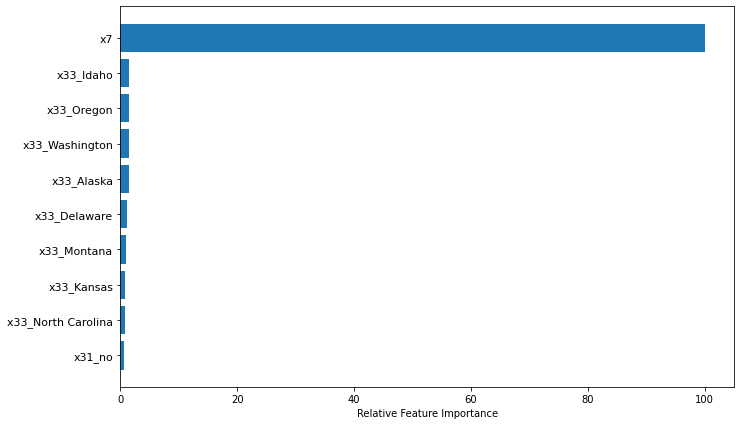

In [28]:
column_names = imp.get_feature_names_out()
fi = abs(gscv.best_estimator_.coef_)[0] # absolute value of coefficient estimates
fi = (fi/fi.max())*100.0 # scale by largest value
idx = np.argsort(fi)[-10:] # sort by relative importance and subset top 10
pos = np.arange(idx.shape[0]) + .5
fig = plt.figure()
fig.set_size_inches(11,7)
ax = fig.add_subplot(1, 1, 1)
ax.barh(pos, fi[idx], align = 'center')
ax.set_yticks(pos)
ax.set_yticklabels(np.array(column_names)[idx], fontsize = 11)
ax.set_xlabel('Relative Feature Importance')
plt.show()

In [29]:
Y_pred = gscv.best_estimator_.predict_proba(Xva)[:,1]
cc_y, cc_x = calibration_curve(y_true = Yva, 
                               y_prob = Y_pred, 
                               n_bins = 10) # for calibration plot later

Use the optimal L1 hyperparameter from grid search cross validation to train a calibrated classifier that uses Platt scaling. Then use this trained classifier to visualize the learning curves across different data set sizes to help diagnose potential issues from bias or variance.

In [30]:
reg_model = LogisticRegression(C = gscv.best_params_['C'], # optimal parameter from grid search cv
                               penalty = 'l1',
                               solver = 'liblinear',
                               max_iter = 10000,
                               verbose = 0)

reg_model_c = CalibratedClassifierCV(base_estimator = reg_model,
                                     method = 'sigmoid', # platt scaling for calibration
                                     ensemble = True,
                                     n_jobs = -1)

train_sizes, train_scores, valid_scores = learning_curve(reg_model_c,
                                                         Xtr,
                                                         np.array(Ytr).ravel(),
                                                         train_sizes = np.linspace(0.2,1,20),
                                                         cv = skf.split(Xtr, Ytr),
                                                         scoring = make_scorer(average_precision_score))

train_scores = [np.mean(m) for m in train_scores] # average precision across the cv folds
valid_scores = [np.mean(m) for m in valid_scores]

#### Visualize Baseline Learning Curves

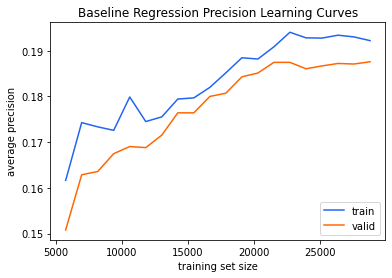

In [31]:
plt.plot(train_sizes, train_scores, color = '#2164F3') # training precision for baseline model
plt.plot(train_sizes, valid_scores, color = '#FF6600') # validation precision for baseline model
plt.title(f'Baseline Regression Precision Learning Curves')
plt.ylabel(f'average precision')
plt.xlabel('training set size')
plt.legend(['train', 'valid'],
           loc = 'lower right')
plt.show()

The variance gap doesn't seem too large but the average precision is really low. It seems like gathering more data would improve the performance slightly as the learning curves have not flattened out as the training set size is increased.

In [32]:
reg_model_c = CalibratedClassifierCV(base_estimator = reg_model,
                                     method = 'sigmoid', # platt scaling for calibration
                                     ensemble = True,
                                     n_jobs = -1,
                                     cv = skf.split(Xtr, Ytr))
reg_model_c.fit(Xtr, np.array(Ytr).ravel()) # calibrated baseline logistic regression with lasso penalty

Y_pred_c = reg_model_c.predict_proba(Xva)[:,1]
cc_cal_y, cc_cal_x = calibration_curve(y_true = Yva, 
                                       y_prob = Y_pred_c,
                                       n_bins = 10) # for calibration plot further below

#### Boosted Trees Classifier ML Model
Train a boosted trees classifier for comparison. The boosting algorithm could reduce bias and improve the expected performance.

In [33]:
param_grid = {"max_depth": [3,5,7],
              "learning_rate": [0.0001,0.001,0.01,0.1],
              "subsample": [0.01,0.1,0.5]}

ml_model = GradientBoostingClassifier(loss = 'log_loss')

gscv_ml = GridSearchCV(ml_model,
                       scoring = 'neg_log_loss',
                       param_grid = param_grid,
                       cv = skf.split(Xtr, Ytr))

gscv_ml.fit(Xtr, np.array(Ytr).ravel())

GridSearchCV(cv=<generator object _BaseKFold.split at 0x147cad120>,
             estimator=GradientBoostingClassifier(),
             param_grid={'learning_rate': [0.0001, 0.001, 0.01, 0.1],
                         'max_depth': [3, 5, 7],
                         'subsample': [0.01, 0.1, 0.5]},
             scoring='neg_log_loss')

In [34]:
gscv_ml.best_params_ # best parameters from grid search cross validation

{'learning_rate': 0.1, 'max_depth': 3, 'subsample': 0.5}

In [35]:
ml_model = GradientBoostingClassifier(loss = 'log_loss',
                                      max_depth = gscv_ml.best_params_['max_depth'],
                                      learning_rate = gscv_ml.best_params_['learning_rate'],
                                      subsample = gscv_ml.best_params_['subsample'])
ml_model.fit(Xtr, np.array(Ytr).ravel())

GradientBoostingClassifier(subsample=0.5)

In [36]:
Y_pred_ml = ml_model.predict_proba(Xva)[:,1]
cc_ml_y, cc_ml_x = calibration_curve(y_true = Yva, 
                                     y_prob = Y_pred_ml,
                                     n_bins = 10) # for ml model calibration plot 

#### Calibration Curves
Plot of the calibration curves of the base logistic regression model without the use of Platt Scaling for calibrating probabilities, the calibrated final baseline logistic regression, which uses Platt Scaling for calibration, and the boosted trees ML model. The final calibrated baseline model and the ML boosted trees models will use all of the available data or training before estimating the test set probabilities.

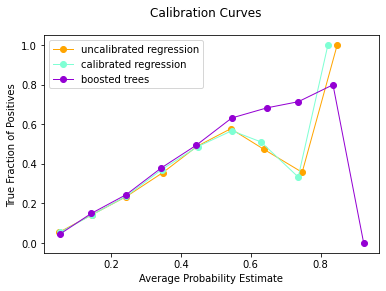

In [37]:
fig, ax = plt.subplots()
plt.plot(cc_x, 
         cc_y, 
         marker = 'o', 
         linewidth = 1, 
         color = 'orange',
         label = 'uncalibrated regression')

plt.plot(cc_cal_x, 
         cc_cal_y, 
         marker = 'o', 
         linewidth = 1,
         color = 'aquamarine',
         label = 'calibrated regression')

plt.plot(cc_ml_x, 
         cc_ml_y, 
         marker = 'o', 
         linewidth = 1,
         color = 'darkviolet',
         label = 'boosted trees')

fig.suptitle('Calibration Curves')
ax.set_xlabel('Average Probability Estimate')
ax.set_ylabel('True Fraction of Positives')
plt.legend()
plt.show()

#### Performance Comparison
Compare the performance of the calibrated baseline logsitic regression model to that of the boosted trees model using the average ROC AUC over the stratified cross validation folds. This should give a reasonable expectation of the test set performance. Use all of the available data for training.

In [38]:
Xtr = np.vstack((Xtr, Xva)) # combine into a single training set
Ytr = pd.concat([Ytr, Yva])

In [39]:
Xtr.shape, Ytr.shape

((40000, 221), (40000, 1))

In [40]:
reg_model_c = CalibratedClassifierCV(base_estimator = reg_model,
                                     method = 'sigmoid', # platt scaling for calibration
                                     ensemble = True)

cv_score_baseline = cv_score(reg_model_c,
                             Xtr,
                             np.array(Ytr).ravel(),
                             cv = skf.split(Xtr, Ytr),
                             scoring = make_scorer(roc_auc_score), # graded on ROC AUC
                             n_jobs = -1)

ml_model = GradientBoostingClassifier(loss = 'log_loss',
                                      max_depth = gscv_ml.best_params_['max_depth'],
                                      learning_rate = gscv_ml.best_params_['learning_rate'],
                                      subsample = gscv_ml.best_params_['subsample'])

cv_score_ml = cv_score(ml_model,
                       Xtr,
                       np.array(Ytr).ravel(),
                       cv = skf.split(Xtr, Ytr),
                       scoring = make_scorer(roc_auc_score), # graded on ROC AUC
                       n_jobs = -1)

In [41]:
print(f"The expected ROC AUC from the baseline model is {round(np.mean(cv_score_baseline), 3)}.")
print(f"The expected ROC AUC from the ML model is {round(np.mean(cv_score_ml), 3)}.")

The expected ROC AUC from the baseline model is 0.54.
The expected ROC AUC from the ML model is 0.556.


#### Test Set Predictions

In [42]:
reg_model_c.fit(Xtr, np.array(Ytr).ravel())
ml_model.fit(Xtr, np.array(Ytr).ravel()) # train models using all available training data

pred_baseline = reg_model_c.predict_proba(Xte)[:,1]
pred_baseline = pd.DataFrame([round(p, 4) for p in pred_baseline])
pred_ml = ml_model.predict_proba(Xte)[:,1]
pred_ml = pd.DataFrame([round(p, 4) for p in pred_ml])

pred_baseline.to_csv(DATA_PATH + 'glmresults.csv', 
                     index = False,
                     header = False)
pred_ml.to_csv(DATA_PATH + 'nonglmresults.csv', 
               index = False,
               header = False)

In [43]:
reg_model_c.classes_ # make sure col 1 is positive class

array([0, 1])

In [44]:
ml_model.classes_

array([0, 1])